In [283]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

# Introduction

Recall the monkey psychophysics experiment from the last tutorial, where a monkey had to discriminate the movement direction of dots for varying degrees of motion coherence. We will now focus on understanding the monkeys' reaction times. In the first part, we'll analyze the data further to see how the reaction time distributions look like. In the second part, we aim to understand these distributions in the framework of the drift diffusion model.

## Prerequisites

- two-alternative forced choice task
- Drift Diffusion Model
- basic Python skills, including plotting, histograms, some numpy and functions

## Objectives

- What do reaction time distributions look like?
- How do distributions for correct and incorrect trials differ?
- How can these properties be understood in terms of the Drift Diffusion Model?
- simulate the Drift Diffusion Model

# Problem 1: Reaction time distributions in psychophysics data

## Load the data

As before, the data we will use is in a file called `dots_psychophysics.txt` in the directory `data`. Compared to the last tutorial, the data file contains one additional column, the reaction times, i.e. the now five columns represent:

**coherence direction choice correct reactiontime**,

where `coherence` is the strength of the stimulus, `direction` is the true direction of the stimulus, `choice` is the choice the monkey made and `correct` specifies whether the answer was correct (and the animal rewarded) and `reaction time` is how long it took the monkey to respond (in ms).

Now load the data. 

In [284]:
df = pd.read_csv("data/dots_psychophysics.txt", header = None, delimiter="  ")
df.rename(columns={0: 'coherence', 1: 'direction', 2: 'choice', 3: 'correct', 4: 'reaction time'}, inplace=True)

/opt/conda/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


## Plotting reaction time distributions

Let's get a feel for reaction times by plotting histograms as a function of `coherence` and `correct` response.

1. Plot the mean reaction time as a function of coherence.
2. Plot the above separately for correct and incorrect trials.
3. Plot the distribution of reaction times for different coherence. Ideally, plot reaction time for correct and error separately in the same figure, along the positive and negative y-axis, respectively.

Useful functions: np.histogram, plt.bar, plt.hist. 

Hint: Write your own function to plot the reaction time distribution so that we can reuse it later. This function will take three parameters: reaction times for correct, and for incorrect trials, as well as a parameter determining the histogram bins. It will plot histograms for the two distributions along the positive and negative y-axis using the same bins size. Here's an example of what the plot should look like:

![example](fig/RT_coh06.png)

In [337]:
def reaction_time_plot(correct, incorrect, bins = 20, maxtime = 2500):
    correct_hist, bin_edges  = np.histogram(correct, bins = bins, range = (0, maxtime))
    incorrect_hist, bin_edges  = np.histogram(incorrect, bins = bins, range = (0, maxtime))
    time = bin_edges[0:-1]
    count = len(correct) + len(incorrect)
    plt.bar(time, correct_hist / count, width = maxtime / bins / 1.2 , color = "blue")
    plt.bar(time, -incorrect_hist / count, width = maxtime / bins / 1.2, color = "red")
    plt.xlabel("Reaction Time")
    plt.ylabel("Proportion")
    plt.title("Coh %.2f Prop. Correct %.2f, Mean RT %d/%d ms" % \
              (coh, len(correct) / (len(incorrect) + len(correct)), np.mean(correct), np.mean(incorrect)))
    return time + 0.5 * (time[1] - time[0])

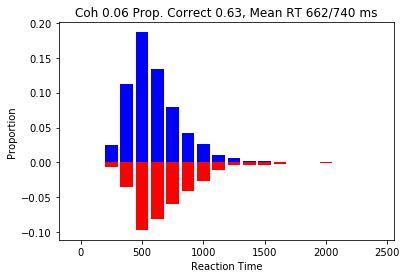

In [338]:
coh = 0.064
correct = df[(df["direction"] == df["choice"]) & (df["coherence"] == coh)]["reaction time"]
incorrect =  df[(df["direction"] != df["choice"]) & (df["coherence"] == coh)]["reaction time"]
reaction_time_plot(correct, incorrect)
plt.show()

# Problem 2: Drift Diffusion Model (DDM)

Now that we have looked at the monkey's raw reaction time and accuracy data from this discrimination task, we can begin to think about how to model this data. As you saw in the lecture before, DDMs predict both RT and choice accuracy data and have been used to model behavior in this sort of sequential discimination task.

** Short summary of the Drift diffusion model **

The Drift Diffusion Model arises from the Sequential Probability Ratio Test in the limit where discretely presented evidence becomes continuously presented evidence. Mathematically, the DDM is given as a stochastic differential equation

\begin{eqnarray}
dx = \mu dt + \sigma dW,
\end{eqnarray}

where
$\mu$ : Drift rate, 
$\sigma$ : Noise standard deviation, 
$dW$ : White Noise.

Ignoring the boundary conditions, the distribution of increments of $x$ from time $s$ to time $t$ is a normal distribution $\mathcal{N}$ with mean $\mu (t-s)$ and standard deviation $\sigma \sqrt{t-s}$, $(s\leq t)$:
\begin{eqnarray}
X_t-X_s \sim \mathcal{N}(\mu (t-s), \sigma \sqrt{t-s}).
\end{eqnarray}

In discrete time form, the increment of the decision variable $\Delta x$ after time $\Delta t$ is
\begin{eqnarray}
\Delta x \sim \mathcal{N}(\mu \Delta t, \sigma \sqrt{\Delta t}).
\end{eqnarray}

Now consider two absorbing boundaries at $\pm B$. A decision is committed once the decision variable reaches one of the boundaries. In other words, the decision variable is "absorbed" by the boundary.

*References:*

Ratcliff, Roger. "A theory of memory retrieval." Psychological review 85.2 (1978): 59.

Bogacz, Rafal, et al. "The physics of optimal decision making: a formal analysis of models of performance in two-alternative forced-choice tasks." Psychological review 113.4 (2006): 700.

**In this exercise** we'll write a function that simulates RTs and choices using a DDM with constant decision boundaries. We will plot this data, using the function written above, and in doing this we will begin to see how the model generated behavior compares to the monkey RT and choice data. In particular, we will play with some of the parameters of the DDM and look at the effects this has on the simulated data. In order to simulate the data, remember the key equations of the DDM:

\begin{eqnarray}
\Delta x \sim \mathcal{N}(\mu \Delta t, \sigma \sqrt{\Delta t}).
\end{eqnarray}

which describes the incremental change in the decision variable $\Delta x$ after time $\Delta t$.

Next, we will relax certain conditions of the DDM and see how this affects the simulated behavior. In particular, we will introduce time-varying drift and collapsing decision bounds. 

Finally, we will look at the analytical DDM and graphically compare its predictions to our simulated RT data.

## Constant bound DDM simulation

### Decision variable trajectory

1. Write a function that simulates one trial of the DDM. The function should take parameters $\mu$, $\sigma$, and a boundary $B$ as inputs and return the choice, correctness, and reaction time for that trial, as well as the simulated trace of the decision variable (x in the equation above) and the times at which the decision variable was sampled in the simulation.
2. Plot the decision variable trajectories for 200 trials in the same figure with the following parameters: $\mu=1.5 \cdot 10^{-3}$, $\sigma=0.05$, $B=1$.
3. (Optional) Change the parameters $\mu, \sigma$, and observe the change in the decision variable density.

Hints: 

- adjust the alpha value of a plot to show more trajectories
- to obtain reproducible results in code that uses random numbers, set the "random seed" (np.random.seed) to an integer value of your choice (we used the trial number as seed)

In [307]:
def DDM(mu, sigma, B, plot = True):
    dt = 0.1
    time = np.arange(0, 2500, dt)
    traj = []
    choice, corrected, reaction_time = 0, False, 2500
    
    x = 0
    for t in time:
        if x < B and x > -B:
            x += mu * dt + sigma * np.sqrt(dt) * np.random.randn()
            traj.append(x)
        elif x > B:
            choice, corrected, reaction_time = 1, True, t
            break
        elif x < -B:
            choice, corrected, reaction_time = -1, False, t
            break
    if plot:
        plt.plot(time[0:len(traj)], traj, color = "black", alpha = 0.1)
    return choice, corrected, reaction_time

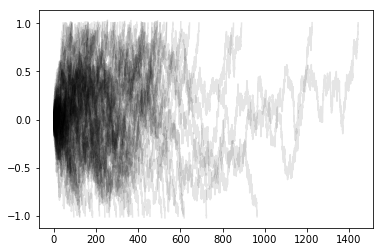

In [308]:
mu, sigma, B = 1.5e-3, 0.05, 1
for i in range(100):
    DDM(mu, sigma, B)

**Expected Output**
<img src="fig/Sim_DDM_cb_DVtrajectories.png">

### Reaction time distribution

1. Simulate the DDM for 5000 trials with $\mu=0.0015, \sigma=0.05, B=1$.
2. Plot the reaction time distribution, separating correct from error trials.

Hint: Use your plotting function from the first exercise!

In [309]:
mu, sigma, B = 0.0015, 0.05, 1

def reaction_time_simulation(mu, sigma, B, bins = 20, N = 5000):
    correct, incorrect = [], []
    for i in range(N):
        choice, corrected, reaction_time = DDM(mu, sigma, B, plot = False)
        if corrected:
            correct.append(reaction_time)
        else:
            incorrect.append(reaction_time) 
    return reaction_time_plot(correct, incorrect, bins = bins)

array([   62.5,   187.5,   312.5,   437.5,   562.5,   687.5,   812.5,
         937.5,  1062.5,  1187.5,  1312.5,  1437.5,  1562.5,  1687.5,
        1812.5,  1937.5,  2062.5,  2187.5,  2312.5,  2437.5])

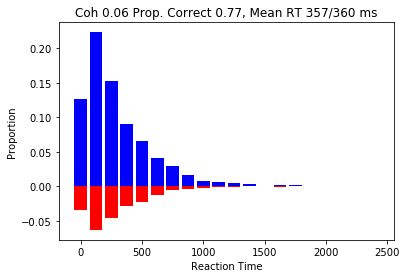

In [310]:
reaction_time_simulation(mu, sigma, B)

**Expected Output**
<img src="fig/Sim_DDM_cb_RTdistributions.png">

## Analytical solution of classical DDM

One can obtain an analytic solution for the reaction time distribution of the drift diffusion model, which we provide here. Don't worry about the inner working of the function, just how to use it.

*Reference*

Anderson, Theodore W. "A modification of the sequential probability ratio test to reduce the sample size." The Annals of Mathematical Statistics (1960): 165-197.

- import the function 'analytic_ddm' from the ddm module in the 'src' folder.
- look at the docstring of the function to see what parameters it takes and what it returns (in the notebook you can append '?' to the function name)

In [311]:
from src.ddm import analytic_ddm

In [312]:
?analytic_ddm

## Comparison between analytic and simulated solution

1. Compare the analytical solution with simulation results (use 10,000 trials): $\mu=1e-3, \sigma=0.05, B=1$.
2. Compare the time taken by the simulation and analytical calculation.

Hints:

- When comparing analytical and simulated RT histograms, make sure the normalizations of the histograms are consistent
- Useful function: time.time()

In [353]:
def reaction_time_compare(mu, sigma, B, bins = 30, N = 10000):
    time = reaction_time_simulation(mu, sigma, B, bins = bins, N = N)
    dist_cor, dist_err = analytic_ddm(mu, sigma, B, time)
    count = sum(dist_cor) + sum(dist_err)
    dist_cor, dist_err = dist_cor / count, dist_err / count
    plt.plot(time, dist_cor, time, -dist_err)   

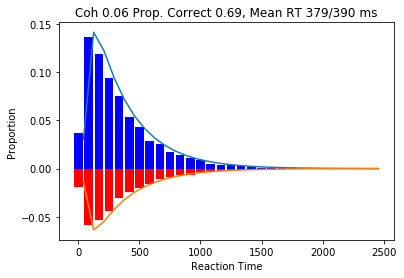

In [314]:
mu, sigma, B = 1e-3, 0.05, 1  
reaction_time_compare(mu, sigma, B)

**Expected Output**
<img src="fig/Cmp_Sim_Ana_cb.png">

# [Small project] Time-varying parameters

1. Rewrite your DDM simulation function to allow its parameters $\mu$, $\sigma$ and $B$ to be arbitrary functions of time.

2. Simulate the DDM for 5000 trials with a time-varying drift $\mu=1.5\cdot 10^{-6}\cdot t$, and  $\sigma=0.05, B=1$. Plot the RT distribution, separating correct and error trials, and compare their corresponding mean RTs.

3. Simulate the DDM for 5000 trials with a collapsing bound $B = 2(1-t/\tau)$, and $\tau=2000\textrm{ms}, \mu=0.0015$, $\sigma=0.05$. Plot the RT distribution, separating correct and error trials, and compare their corresponding mean RTs.

3. Compare the analytical solution and simulation results, but with linear collaping bounds: $B(t) = 2(1-t/\tau)$, and $\tau=2000\textrm{ms}, \mu=0.0015$, $\sigma=0.05$.

In [343]:
def DDM(mu, sigma, B, plot = True):
    dt = 0.1
    time = np.arange(0, 2500, dt)
    traj = []
    choice, corrected, reaction_time = 0, False, 2500
    
    x = 0
    for t in time:
        if x < B(t) and x > -B(t):
            x += mu(t) * dt + sigma(t) * np.sqrt(dt) * np.random.randn()
            traj.append(x)
        elif x > B(t):
            choice, corrected, reaction_time = 1, True, t
            break
        elif x < -B(t):
            choice, corrected, reaction_time = -1, False, t
            break
    if plot:
        plt.plot(time[0:len(traj)], traj, color = "black", alpha = 0.1)
    return choice, corrected, reaction_time

array([   62.5,   187.5,   312.5,   437.5,   562.5,   687.5,   812.5,
         937.5,  1062.5,  1187.5,  1312.5,  1437.5,  1562.5,  1687.5,
        1812.5,  1937.5,  2062.5,  2187.5,  2312.5,  2437.5])

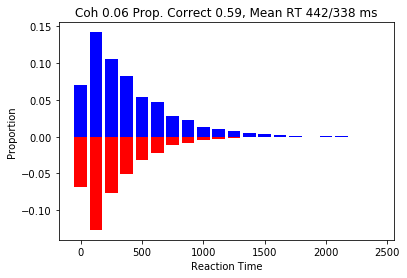

In [349]:
def mu(t):
    return 1.5e-6 * t
def sigma(t):
    return 0.05
def B(t):
    return 1
reaction_time_simulation(mu, sigma, B)

**Expected Output**
<img src="fig/Sim_DDM_vb_mu_RTdistribution.png">

array([   62.5,   187.5,   312.5,   437.5,   562.5,   687.5,   812.5,
         937.5,  1062.5,  1187.5,  1312.5,  1437.5,  1562.5,  1687.5,
        1812.5,  1937.5,  2062.5,  2187.5,  2312.5,  2437.5])

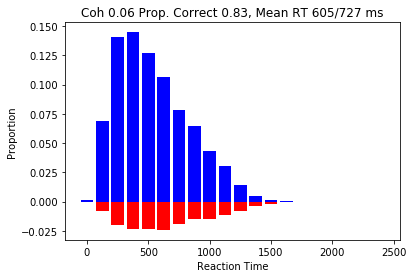

In [352]:
def mu(t):
    return 0.0015
def sigma(t):
    return 0.05
def B(t):
    return 2 * (1 - t / 2000)

reaction_time_simulation(mu, sigma, B)

**Expected Output**
<img src="fig/Sim_DDM_vb_B_RTdistribution.png">

TypeError: unsupported operand type(s) for /=: 'function' and 'function'

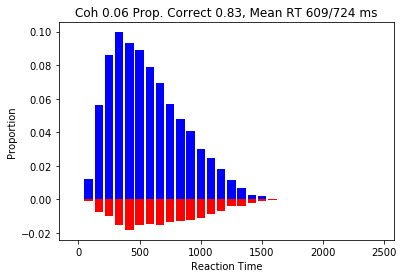

In [354]:
def mu(t):
    return 0.0015
def sigma(t):
    return 0.05
def B(t):
    return 2 * (1 - t / float(2000))

reaction_time_compare(mu, sigma, B)

**Expected Output**
<img src="fig/Cmp_Sim_Ana_vb.png">